# Production Technology

The dataset contains `N = 441` firms observed over `T = 12` years, 1968-1979. There variables are: 
* `lcap`: Log of capital stock, $k_{it}$ 
* `lemp`: log of employment, $\ell_{it}$ 
* `ldsa`: log of deflated sales, $y_{it}$
* `year`: the calendar year of the observation, `year` $ = 1968, ..., 1979$, 
* `firmid`: anonymized indicator variable for the firm, $i = 1, ..., N$, with $N=441$. 

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import os
print(os.listdir())
import project_1 as est
%load_ext autoreload
%autoreload 2

['2025-09_Project_1.pdf', 'project_1.py', 'firms.csv', '__pycache__', 'read (1).ipynb']


In [2]:
dat = pd.read_csv('firms.csv')

# Descriptives

In [7]:
dat.describe()

,firmid,year,lcap,lemp,ldsa,cap,emp,dsa
count,5292.000000,5292.000000,5.292000e+03,5.292000e+03,5.292000e+03,5292.000000,5292.000000,5292.000000
mean,221.000000,1973.500000,-7.125472e-09,-1.252834e-08,4.695767e-09,2.524362,2.058392,2.233077
std,127.317437,3.452379,1.310973e+00,1.180122e+00,1.232499e+00,5.078836,3.140873,3.800031
min,1.000000,1968.000000,-3.864950e+00,-3.382780e+00,-3.551540e+00,0.020964,0.033953,0.028680
25%,111.000000,1970.750000,-9.083267e-01,-7.855270e-01,-9.279720e-01,0.403198,0.455879,0.395355
50%,221.000000,1973.500000,-1.180615e-01,-1.137295e-01,-1.029710e-01,0.888641,0.892499,0.902154
75%,331.000000,1976.250000,9.063340e-01,7.930060e-01,8.562296e-01,2.475235,2.210030,2.354268
max,441.000000,1979.000000,4.103687e+00,3.371332e+00,3.913391e+00,60.563173,29.117285,50.068447


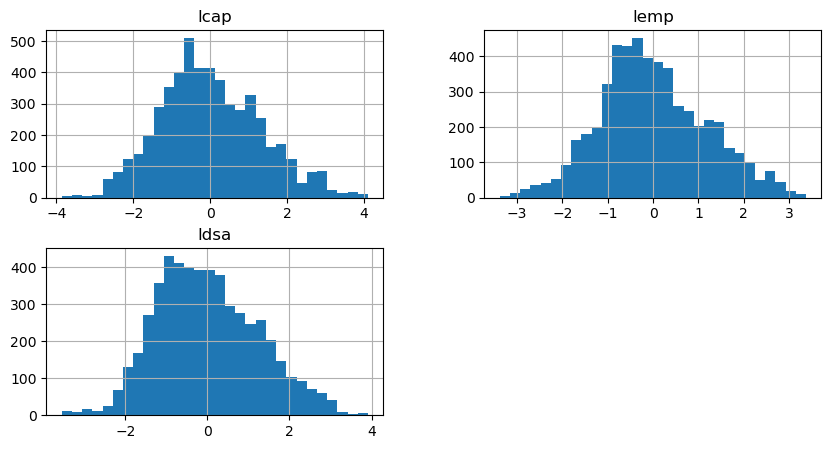

In [4]:
dat[['lcap','lemp','ldsa']].hist(bins=30, figsize=(10,5));
# ser ud til at være nogenlunde normalfordelte

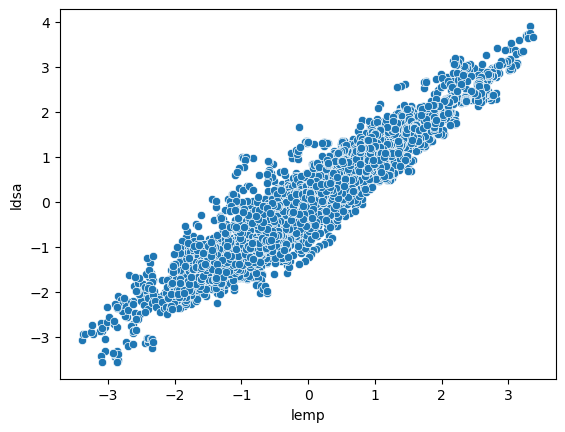

In [5]:
sns.scatterplot(x='lemp', y='ldsa', data=dat); 
# umiddelbart ser log ansatte ud til at være positivt korreleret med log omsætning

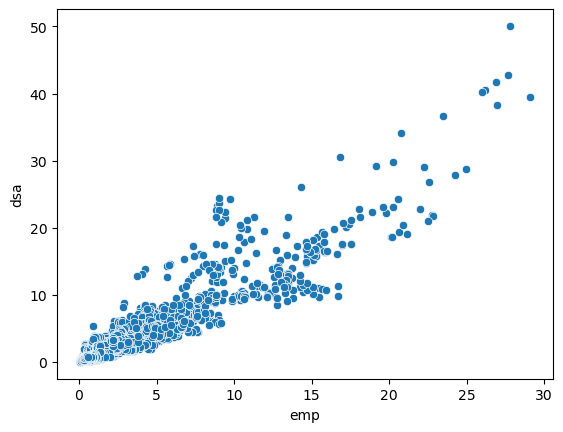

In [6]:
#De-log-transform variables 
dat['cap'] = np.exp(dat['lcap'])
dat['emp'] = np.exp(dat['lemp'])
dat['dsa'] = np.exp(dat['ldsa'])

sns.scatterplot(x='emp', y='dsa', data=dat); 

# Converting data to numpy format 

In [8]:
dat.ldsa.values.shape

(5292,)

In [ ]:
#Define N and T for our models 
N = dat.firmid.unique().size
T = dat.year.unique().size
assert dat.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T}')

Data has N=441 and T=12


In [10]:
#Define sales as our dependent variable 
y = dat.ldsa.values.reshape((N*T,1))

#Laver et konstantled som repræsenterer det teknologiske niveau, A og definerer vores X matrix
ones = np.ones((N*T,1)) 
l = dat.lemp.values.reshape((N*T,1))
k = dat.lcap.values.reshape((N*T,1))
X = np.hstack([ones, l, k])
label_y = 'log_omsætning'
label_x = ['const', 'log_ansatte', 'log_kapital']

#Rename columns for easier reading
rename_dict = {'year': 'aar', 'ldsa':'log_omsætning', 'lemp': 'log_ansatte', 'lcap': 'log_kapital'}
dat = dat.rename(columns=rename_dict)

# OLS

In [ ]:
#Estimerer pooled ols for benchmark 
pooled_result = est.estimate(y, X, T=T)
est.print_table((label_y, label_x), pooled_result, title='Pooled OLS regression', floatfmt='.4f')

Pooled OLS regression
Dependent variable: log_omsætning

               Beta      Se    t-values
-----------  ------  ------  ----------
const        0.0000  0.0050      0.0000
log_ansatte  0.6748  0.0102     66.4625
log_kapital  0.3100  0.0091     33.9237
R² = 0.914
σ² = 0.131


# FE

In [13]:
###Transform the data#####
# Create transformation matrix
Q_T = np.eye(T) - np.ones((T, T)) / T  
#Print dimension of Q_T
print(f'Dimension of Q_T: {Q_T.shape}')

#Create y and x dot using the perm function
y_dot = est.perm(Q_T, y.reshape(-1, 1))           # (N*T, 1)
x_dot = est.perm(Q_T, X)                           # (N*T, K)


# Estimate the fe model using the estimate function
fe_result = est.estimate(y_dot, x_dot, robust_se=True, transform='fe', T=T)
est.print_table((label_y, label_x), fe_result, title="Fixed Effects", floatfmt='.4f')

Dimension of Q_T: (12, 12)
Fixed Effects
Dependent variable: log_omsætning

                       Beta                   Se    t-values
-----------  --------------  -------------------  ----------
const        155239401.2793  33608578551910.4375      0.0000
log_ansatte          0.6942               0.0417     16.6674
log_kapital          0.1546               0.0299      5.1630
R² = 0.477
σ² = 0.018


# RE

In [16]:
############################### The between estimator ###############################   
#Calculate P_T
P_T = np.ones((1, T)) / T
#Print the shape of P_T
print(f'Dimension of P_T: {P_T.shape}')

y_mean = est.perm(P_T, y.reshape(-1, 1))   # (N*T,   )
x_mean = est.perm(P_T, X)           # (N*T, K )

#Estimate the between model using the estimate function
be_result = est.estimate(y_mean, x_mean, robust_se=True, transform='be', T=T)
est.print_table((label_y, label_x), be_result, title="Between Estimator", floatfmt='.4f')

Dimension of P_T: (1, 12)
Between Estimator
Dependent variable: log_omsætning

               Beta      Se    t-values
-----------  ------  ------  ----------
const        0.0000  0.0137      0.0000
log_ansatte  0.6672  0.0412     16.2107
log_kapital  0.3188  0.0349      9.1438
R² = 0.923
σ² = 0.115


In [17]:
############################## Calculate lambda ########################
sigma2_u = fe_result['sigma2']
sigma2_w = float(((u := (np.asarray(y_mean).reshape(-1,1) - np.asarray(x_mean) @ np.asarray(be_result['b_hat']).reshape(-1,1))).T @ u) / (np.asarray(x_mean).shape[0] - np.asarray(x_mean).shape[1]))
sigma2_c = sigma2_w - (sigma2_u / T)
_lambda = 1 - np.sqrt(sigma2_u / (T * sigma2_c + sigma2_u))

# Print lambda 
print(f'Lambda is approximately equal to {_lambda.item():.4f}.')

Lambda is approximately equal to 0.8873.


/var/folders/yb/2nwpczt56kvbrmb8klk29wfw0000gn/T/ipykernel_4667/924895852.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma2_w = float(((u := (np.asarray(y_mean).reshape(-1,1) - np.asarray(x_mean) @ np.asarray(be_result['b_hat']).reshape(-1,1))).T @ u) / (np.asarray(x_mean).shape[0] - np.asarray(x_mean).shape[1]))


In [19]:
############################### Estimate RE model ###############################
# # Create the identity matrix with dimension T
I_T = np.eye(T)
#Create C_T using I_T and P_T
C_T = I_T - _lambda @ P_T
#Transform y and x using perm function
y_re = est.perm(C_T, y.reshape(-1, 1))           # (N*T, 1)
x_re = est.perm(C_T, X)                           # (N*T, K)

# Estimate 
re_result = est.estimate(y_re, x_re, robust_se=True, transform='re', T=T)
est.print_table((label_y, label_x), re_result, title="Random Effects", floatfmt='.4f')

Random Effects
Dependent variable: log_omsætning

               Beta      Se    t-values
-----------  ------  ------  ----------
const        0.0000  0.0168      0.0000
log_ansatte  0.7197  0.0335     21.4644
log_kapital  0.1989  0.0261      7.6177
R² = 0.642
σ² = 0.018


## Hausmann 

In [21]:
from numpy import linalg as la
from scipy.stats import chi2

# Unpack the betas 
b_fe = fe_result['b_hat']
b_re = re_result['b_hat']
cov_fe = fe_result['cov']
cov_re = re_result['cov']

b_diff = b_fe - b_re
cov_diff = cov_fe - cov_re
H = b_diff.T @ la.inv(cov_diff) @ b_diff

# Find critical value and p-value at 5% significance level of chi^2 with M degrees of freedom
M = len(b_fe)
crit_val = chi2.ppf(0.95, df=M)
p_val = 1 - chi2.cdf(H, df=M)


# Print the results
print(f'The test statistic is {H.item():.2f}.')
print(f'The critical value at a 5% significance level is {crit_val:.2f}.')
print(f"The p-value is {float(np.asarray(p_val).reshape(-1)[0]):.8f}.")

The test statistic is 10.36.
The critical value at a 5% significance level is 7.81.
The p-value is 0.01576505.


Vi aviser at RE og FE er ens, hvilket indikerer korrelation mellem A og kapital,employees 

## Test for strict exo 

## Hypothesis test

In [23]:
b_hat = fe_result['b_hat']
cov   = fe_result['cov']

from scipy import stats

ansatte_index = label_x.index('log_ansatte')
kapital_index = label_x.index('log_kapital')

# Gør vektorer/matricer klar
b = np.asarray(b_hat).reshape(-1)   # (P,)
V = np.asarray(cov)                 # (P,P)
P = b.size
if V.shape != (P, P):
    raise ValueError(f"Kovarians har forkert form: {V.shape}, forventede {(P,P)}")

# Byg R (1 x P) med 1 på de to relevante koefficienter
R = np.zeros((1, P))
R[0, [ansatte_index, kapital_index]] = 1.0

# Wald-test for H0: beta_kapital + beta_ansatte = 1
num = float(R @ b - 1.0)           # c'β - q, q=1
den = float(R @ V @ R.T)           # c' V c
if not np.isfinite(den) or den <= 0:
    raise ValueError("Variansen af restriktionen er ikke positiv/finitsk; tjek kovarians og indeks.")

wald = (num ** 2) / den
p_value = stats.chi2.sf(wald, df=1)

print(f"Wald test statistic: {wald:.4f}")
print(f"p-value: {p_value:.4g}")

Wald test statistic: 19.4029
p-value: 1.058e-05


/var/folders/yb/2nwpczt56kvbrmb8klk29wfw0000gn/T/ipykernel_4667/3841634096.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num = float(R @ b - 1.0)           # c'β - q, q=1
/var/folders/yb/2nwpczt56kvbrmb8klk29wfw0000gn/T/ipykernel_4667/3841634096.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  den = float(R @ V @ R.T)           # c' V c


Vi afviser klart og tydeligt H0 i FE modellen. Altså der er ikke constant return to scale i data givet at FE-modellen er sand. 